In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plot

In [3]:
opsdb = db.OpsimDatabase('/Users/lynnej/opsim/db/minion_1016_sqlite.db')

In [4]:
outDir = 'sky_compare'
if not(os.path.isdir(outDir)):
    os.mkdir(outDir)
    
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
filtercolors = {'u': 'c', 'g': 'g', 'r': 'y', 'i':'r', 'z': 'm', 'y': 'k'}

In [5]:
data = {}
for f in filterlist:
    data[f] = opsdb.fetchMetricData(colnames=('expMJD', 'lst', 'fieldRA', 'fieldDec', 'altitude', 'azimuth',
                                              'dist2Moon', 'moonPhase', 'moonAlt', 'sunAlt', 'FWHMeff', 'airmass',
                                              'filtSkyBrightness', 'fiveSigmaDepth', 'sims_skybrightness', 'sims_m5'),
                                    sqlconstraint='filter="%s"' % f)                                   

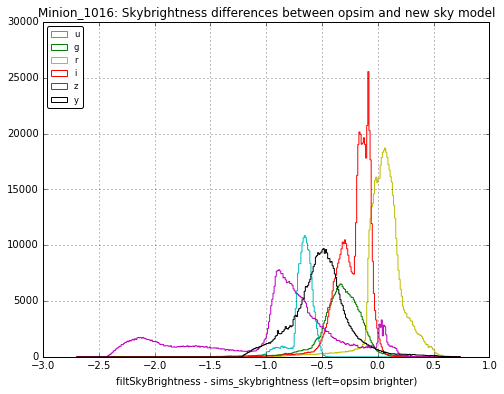

In [6]:
plt.figure(figsize=(8, 6))
b = np.arange(-2.7, 0.75, 0.01)
for f in filterlist:
    dsky = data[f]['filtSkyBrightness'] - data[f]['sims_skybrightness']
    n, b, p = plt.hist(dsky, bins=b, histtype='step', label=f, color=filtercolors[f])
plt.xlabel('filtSkyBrightness - sims_skybrightness (left=opsim brighter)')
plt.title('Minion_1016: Skybrightness differences between opsim and new sky model')
plt.grid(True)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller')

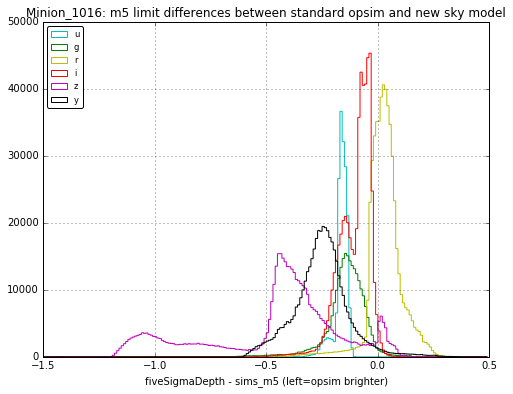

In [7]:
plt.figure(figsize=(8, 6))
b = np.arange(-1.5, 0.5, 0.01)
for f in filterlist:
    dmag = data[f]['fiveSigmaDepth'] - data[f]['sims_m5']
    n, b, p = plt.hist(dmag, bins=b, histtype='step', label=f, color=filtercolors[f])
plt.xlabel('fiveSigmaDepth - sims_m5 (left=opsim brighter)')
plt.title('Minion_1016: m5 limit differences between standard opsim and new sky model')
plt.grid(True)
plt.legend(loc='upper left', fancybox=True, fontsize='smaller')

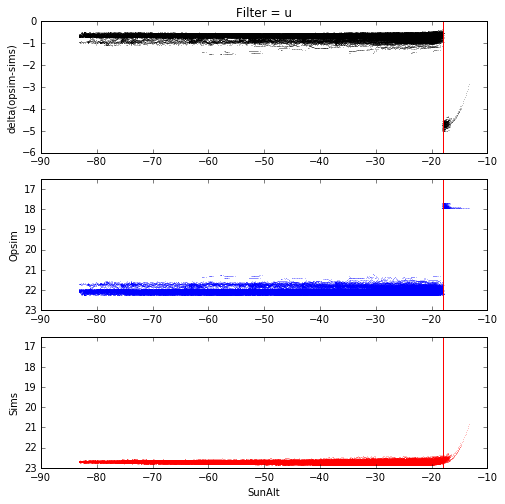

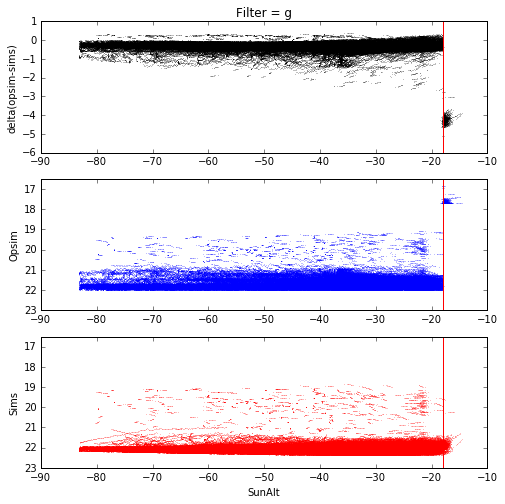

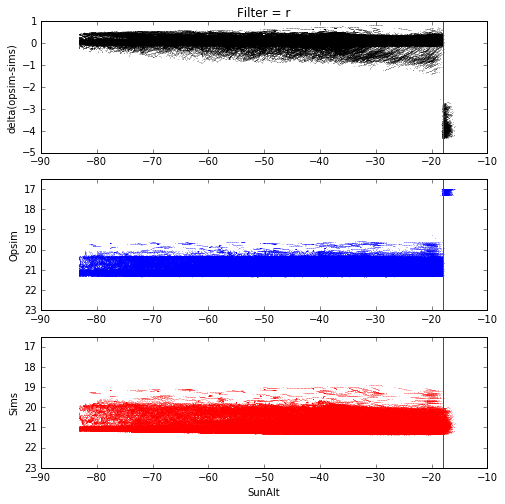

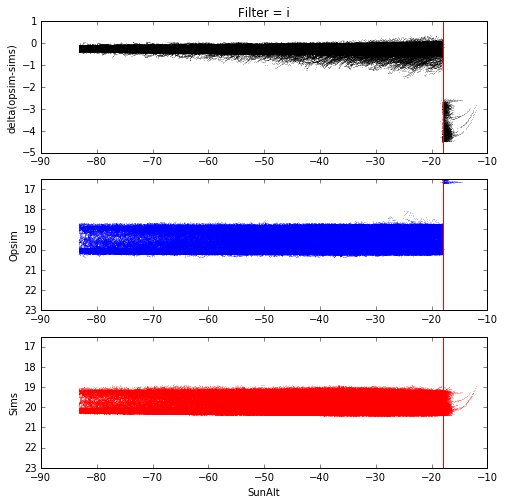

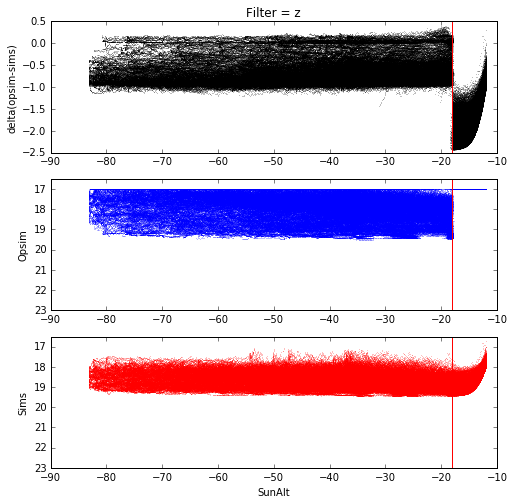

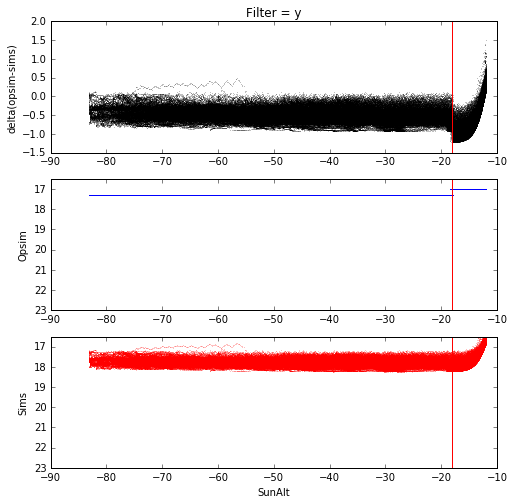

In [8]:
for f in filterlist:
    dsky = data[f]['filtSkyBrightness'] - data[f]['sims_skybrightness']
    plt.figure(figsize=(8, 8))
    plt.subplot(3, 1, 1)
    plt.plot(np.degrees(data[f]['sunAlt']), dsky, 'k.', markersize=0.3)
    plt.axvline(-18, color='r')
    plt.ylabel('delta(opsim-sims)')
    plt.title('Filter = %s' % f)
    plt.subplot(3, 1, 2)
    plt.plot(np.degrees(data[f]['sunAlt']), data[f]['filtSkyBrightness'], 'b.', markersize=0.3)
    plt.ylim(16.5, 23)
    plt.gca().invert_yaxis()
    plt.axvline(-18, color='r')
    plt.ylabel('Opsim')
    plt.subplot(3, 1, 3)
    plt.plot(np.degrees(data[f]['sunAlt']), data[f]['sims_skybrightness'], 'r.', markersize=0.3)
    plt.ylim(16.5, 23)
    plt.gca().invert_yaxis()
    plt.axvline(-18, color='r')
    plt.xlabel('SunAlt')
    plt.ylabel('Sims')
    plt.savefig(os.path.join(outDir, 'skybright_%s.png' % f), format='png')

In [85]:
f = 'r'
sundown = np.where((data[f]['sunAlt'] < np.radians(-20.)), True, False)
moonup = np.where(data[f]['moonAlt'] > 0, True, False)
both = np.where((sundown) & (moonup), True, False)
bothdown = np.where((sundown) & ~(moonup), True, False)

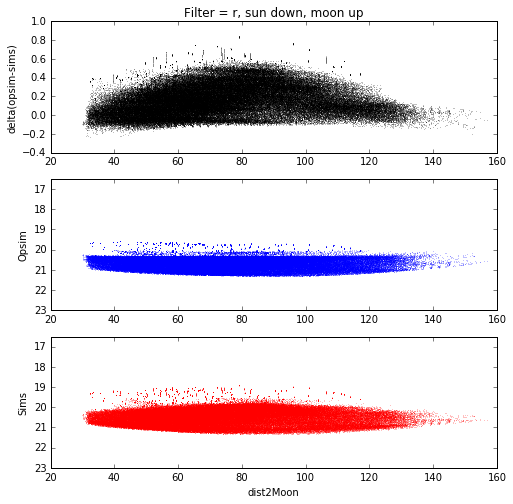

In [91]:
k = 'dist2Moon'
dsky = data[f]['filtSkyBrightness'] - data[f]['sims_skybrightness']
xval = np.degrees(data[f][k])
addparam = np.where(data[f]['altitude'] > np.radians(0), True, False)
subset = np.where(both & addparam)
subset = both
#subset = np.ones(len(dsky), dtype=bool)
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(xval[subset], dsky[subset], 'k.', markersize=0.3)
plt.ylabel('delta(opsim-sims)')
plt.title('Filter = %s, sun down, moon up' % f)
plt.subplot(3, 1, 2)
plt.plot(xval[subset], data[f]['filtSkyBrightness'][subset], 'b.', markersize=0.3)
plt.ylim(16.5, 23)
plt.gca().invert_yaxis()
plt.ylabel('Opsim')
plt.subplot(3, 1, 3)
plt.plot(xval[subset], data[f]['sims_skybrightness'][subset], 'r.', markersize=0.3)
plt.ylim(16.5, 23)
plt.gca().invert_yaxis()
plt.xlabel(k)
plt.ylabel('Sims')
plt.savefig(os.path.join(outDir, 'skybright_%s_%s.png' % (k, f)), format='png')

In [ ]:
k2 = 'altitude'
yval = data[f][k2]
plt.plot(xval[subset], dsky[subset])

In [68]:
import pandas as pd
d = pd.DataFrame(data['r'][both], copy=True)
del d['obsHistID']
del d['expMJD']
del d['fieldRA']
del d['fieldDec']
del d['fiveSigmaDepth']
del d['sims_m5']
dsky = d['filtSkyBrightness'] - d['sims_skybrightness']
del d['filtSkyBrightness']
del d['sims_skybrightness']
print d.shape, dsky.shape, dsky[0]

(153748, 9) (153748,) 0.310579


In [69]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, ElasticNetCV

In [72]:
clf = ElasticNetCV()
# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.01)
sfm.fit(d, dsky)
d2 = sfm.transform(d)
print clf
print d2.shape
n_features = d2.shape[1]

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
(153748, 3)


In [73]:
d2

array([[ 0.736552,  0.153882, -0.665083],
       [ 0.745229,  0.15188 , -0.664896],
       [ 0.747014,  0.149877, -0.664837],
       ..., 
       [ 1.437152,  0.74079 , -0.355614],
       [ 1.439288,  0.739695, -0.35721 ],
       [ 1.441417,  0.738595, -0.358803]])

ValueError: x and y must have same first dimension

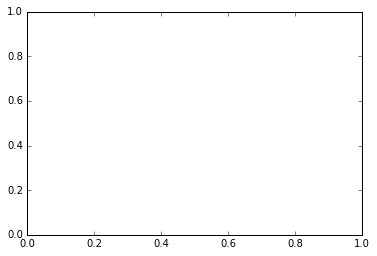

In [84]:
# Plot the selected features from d2, relative to dsky
feature = d2[:, 0]
plt.plot(feature, dsky, 'r.')
plt.xlabel("Feature number ")
plt.show()

In [63]:
from sklearn.linear_model import BayesianRidge
clf = BayesianRidge()
clf.fit(d, dsky)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [64]:
zip(d.columns, clf.coef_)

[('lst', -0.0044465426077416291),
 ('altitude', 0.10301182460593522),
 ('azimuth', 0.00092027632989179664),
 ('dist2Moon', 0.041353973139504514),
 ('moonPhase', 0.0044247588927116095),
 ('moonAlt', 0.14096707219575089),
 ('sunAlt', -0.11546157305110441),
 ('FWHMeff', -0.00047479140926701791),
 ('airmass', -0.02323964733746308)]